Copyright 2020 The Dopamine Authors.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

# Dopamine JAX Agent visualizer

This colaboratory demonstrates how to use the agent visualizer functionality in Dopamine with JAX agents. It provides examples for how to do this with a DQN
and Quantile agent on 6 possible games.

Make sure you select GPU as the hardware accelerator (check under "Runtime > Change runtime type").

Note that it will save all the files to a temp directory in your runtime.

In [ ]:
# @title Install dopamine
!pip install -U dopamine-rl

In [9]:
# @title Imports
from dopamine.discrete_domains import atari_lib
from dopamine.jax.agents.dqn import dqn_agent
from dopamine.jax.agents.implicit_quantile import implicit_quantile_agent
from dopamine.jax.agents.quantile import quantile_agent
from dopamine.jax.agents.rainbow import rainbow_agent
from dopamine.replay_memory import circular_replay_buffer
from dopamine.utils import example_viz_lib
import gin
import jax
import jax.numpy as jnp
import numpy as onp
import os.path as osp
import pathlib
import pickle
import tensorflow as tf

In [31]:
# @title Download a trained checkpoint
agent = 'quantile'  # @param ['dqn', 'c51', 'rainbow', 'quantile', 'implicit_quantile']
game = 'Breakout'  # @param ['Pong', 'SpaceInvaders', 'Seaquest', 'Qbert', 'Breakout', 'Asterix']
!gsutil -q -m cp -R gs://download-dopamine-rl/jax/{agent}/{game}/1/ckpt.199 /tmp

In [21]:
# @title Customized JAX agent subclasses to record q-values, distributions, and  rewards.
class MyDQNAgent(dqn_agent.JaxDQNAgent):
  """Sample JAX DQN agent to visualize Q-values and rewards."""

  def __init__(self, num_actions, summary_writer=None):
    super().__init__(num_actions, summary_writer=summary_writer)
    self.q_values = [[] for _ in range(num_actions)]
    self.rewards = []

  def _record_q_values(self):
    q_values = self.online_network(self.state).q_values
    for i, q_value in enumerate(q_values):
      self.q_values[i].append(q_value)

  def step(self, reward, observation):
    action = super().step(reward, observation)
    self.rewards.append(reward)
    self._record_q_values()
    return action

  def begin_episode(self, observation):
    action = super().begin_episode(observation)
    self._record_q_values()
    return action

  def end_episode(self, reward):
    super().end_episode(reward)
    self.rewards.append(reward)
    self._record_q_values()

  def reload_checkpoint(self, checkpoint_path, use_legacy_checkpoint):
    del use_legacy_checkpoint
    with open(checkpoint_path, 'rb') as f:
      bundle_dictionary = pickle.load(f)
    online_network = self.online_network.replace(
        params=bundle_dictionary['online_params'])
    optimizer_def = dqn_agent.create_optimizer('adam')
    self.optimizer = optimizer_def.create(online_network)
    self.target_network = self.target_network.replace(
        params=bundle_dictionary['target_params'])

  def get_q_values(self):
    return self.q_values

  def get_rewards(self):
    return [onp.cumsum(self.rewards)]


def create_dqn_agent(sess, environment, summary_writer=None):
  del sess
  return MyDQNAgent(num_actions=environment.action_space.n,
                    summary_writer=summary_writer)


class MyRainbowAgent(rainbow_agent.JaxRainbowAgent):
  """Sample JAX Rainbow agent to visualize Q-values and rewards."""

  def __init__(self, num_actions, summary_writer=None):
    super().__init__(num_actions, summary_writer=summary_writer)
    self.rewards = []

  def step(self, reward, observation):
    action = super().step(reward, observation)
    self.rewards.append(reward)
    return action

  def end_episode(self, reward):
    super().end_episode(reward)
    self.rewards.append(reward)

  def reload_checkpoint(self, checkpoint_path, use_legacy_checkpoint):
    del use_legacy_checkpoint
    with open(checkpoint_path, 'rb') as f:
      bundle_dictionary = pickle.load(f)
    online_network = self.online_network.replace(
        params=bundle_dictionary['online_params'])
    optimizer_def = dqn_agent.create_optimizer('adam')
    self.optimizer = optimizer_def.create(online_network)
    self.target_network = self.target_network.replace(
        params=bundle_dictionary['target_params'])

  def get_probabilities(self):
    return jnp.squeeze(self.online_network(self.state).probabilities)

  def get_rewards(self):
    return [onp.cumsum(self.rewards)]


def create_rainbow_agent(sess, environment, summary_writer=None):
  del sess
  return MyRainbowAgent(num_actions=environment.action_space.n,
                        summary_writer=summary_writer)


class MyQuantileAgent(quantile_agent.JaxQuantileAgent):
  """Sample JAX Quantile agent to visualize Q-values and rewards."""

  def __init__(self, num_actions, summary_writer=None):
    super().__init__(num_actions, summary_writer=summary_writer)
    self.rewards = []

  def step(self, reward, observation):
    action = super().step(reward, observation)
    self.rewards.append(reward)
    return action

  def end_episode(self, reward):
    super().end_episode(reward)
    self.rewards.append(reward)

  def reload_checkpoint(self, checkpoint_path, use_legacy_checkpoint):
    del use_legacy_checkpoint
    with open(checkpoint_path, 'rb') as f:
      bundle_dictionary = pickle.load(f)
    online_network = self.online_network.replace(
        params=bundle_dictionary['online_params'])
    optimizer_def = dqn_agent.create_optimizer('adam')
    self.optimizer = optimizer_def.create(online_network)
    self.target_network = self.target_network.replace(
        params=bundle_dictionary['target_params'])

  def get_probabilities(self):
    return jnp.squeeze(self.online_network(self.state).probabilities)

  def get_rewards(self):
    return [onp.cumsum(self.rewards)]


def create_quantile_agent(sess, environment, summary_writer=None):
  del sess
  return MyQuantileAgent(num_actions=environment.action_space.n,
                         summary_writer=summary_writer)


class MyImplicitQuantileAgent(implicit_quantile_agent.JaxImplicitQuantileAgent):
  """Sample JAX IQN agent to visualize Q-values and rewards."""

  def __init__(self, num_actions, summary_writer=None):
    super().__init__(num_actions, summary_writer=summary_writer)
    self.rewards = []

  def step(self, reward, observation):
    action = super().step(reward, observation)
    self.rewards.append(reward)
    return action

  def end_episode(self, reward):
    super().end_episode(reward)
    self.rewards.append(reward)

  def reload_checkpoint(self, checkpoint_path, use_legacy_checkpoint):
    del use_legacy_checkpoint
    with open(checkpoint_path, 'rb') as f:
      bundle_dictionary = pickle.load(f)
    online_network = self.online_network.replace(
        params=bundle_dictionary['online_params'])
    optimizer_def = dqn_agent.create_optimizer('adam')
    self.optimizer = optimizer_def.create(online_network)
    self.target_network = self.target_network.replace(
        params=bundle_dictionary['target_params'])

  def get_q_values(self):
    self._rng, rng = jax.random.split(self._rng)
    return jnp.squeeze(
        self.online_network(self.state,
                            num_quantiles=self.num_quantile_samples,
                            rng=rng).quantile_values)

  def get_rewards(self):
    return [onp.cumsum(self.rewards)]


def create_implicit_quantile_agent(sess, environment, summary_writer=None):
  del sess
  return MyImplicitQuantileAgent(num_actions=environment.action_space.n,
                                 summary_writer=summary_writer)


AGENT_CREATORS = {
    'dqn': create_dqn_agent,
    'c51': create_rainbow_agent,
    'rainbow': create_rainbow_agent,
    'implicit_quantile': create_implicit_quantile_agent,
    'quantile': create_quantile_agent,
}

/usr/local/lib/python3.6/dist-packages/dopamine/utils/line_plotter.py:99: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  self.plot.set_xlim(min_xlim, max_xlim)


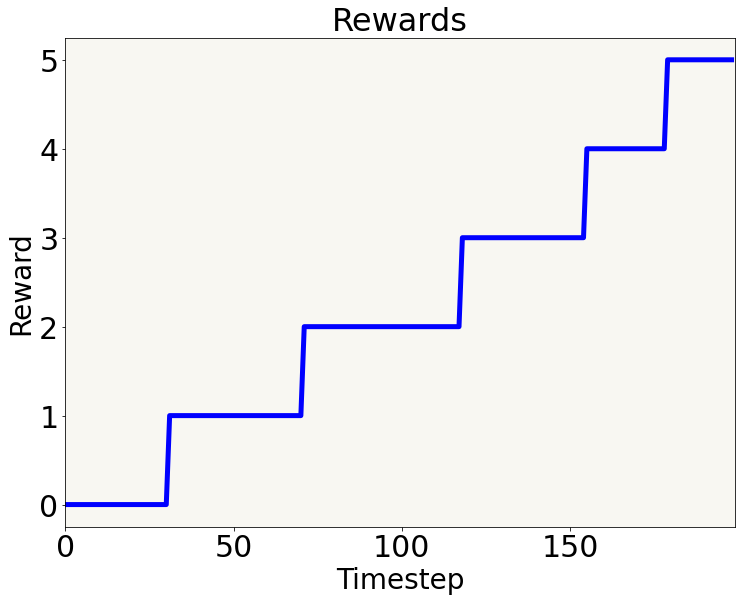

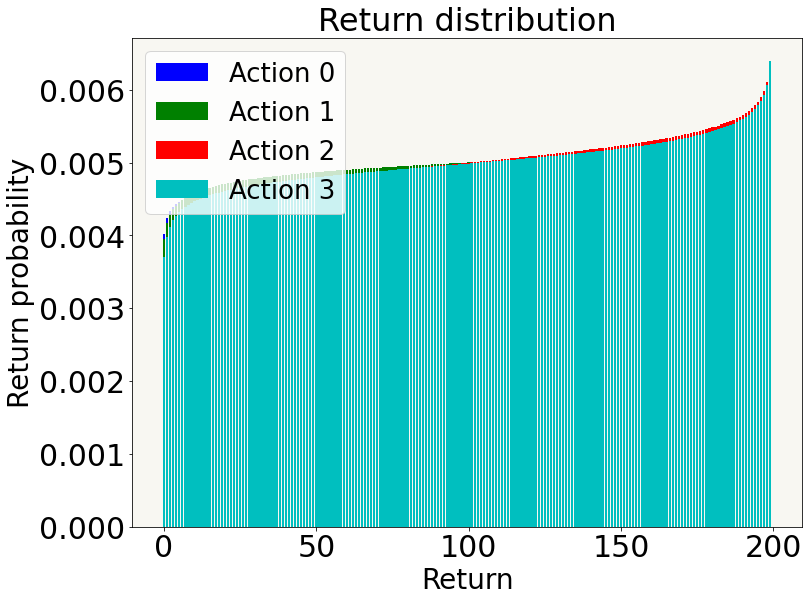

In [32]:
# @title Generate video
num_steps = 200  # @param {type:'slider', min:50, max:500}
tf.compat.v1.reset_default_graph()
config = """
atari_lib.create_atari_environment.game_name = '{}'
OutOfGraphReplayBuffer.batch_size = 32
OutOfGraphReplayBuffer.replay_capacity = 300
OutOfGraphPrioritizedReplayBuffer.batch_size = 32
OutOfGraphPrioritizedReplayBuffer.replay_capacity = 300
""".format(game)
base_dir = pathlib.Path('/tmp/agent_viz') / game / agent
gin.parse_config(config)
runner = example_viz_lib.MyRunner(base_dir, '/tmp/ckpt.199',
                                  AGENT_CREATORS[agent])
runner.visualize(base_dir / 'images', num_global_steps=200)

In [34]:
# @title Display the video
import base64
from IPython.display import HTML
video = (base_dir / 'images/video.mp4').read_bytes()
encoded = base64.b64encode(video).decode('ascii')
HTML(data=f'''<video alt="test" controls>
                <source src="data:video/mp4;base64,{encoded}" type="video/mp4" />
             </video>''')

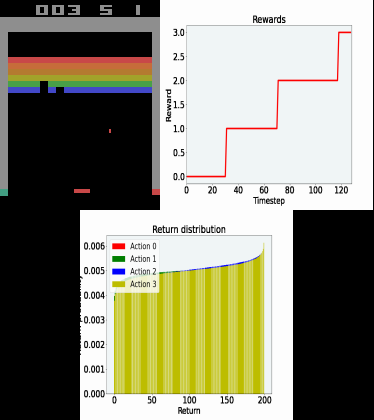

In [35]:
# @title Inspect individual video frames
from IPython.display import Image
frame_number = 128  # @param {type:"slider", min:0, max:999, step:1}
image_file = base_dir / f'images/frame_{frame_number:06d}.png'
Image(image_file)